In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
import joblib

In [62]:
df = pd.read_csv('ohca_13_18_final.csv')

In [63]:
df2 = df

In [64]:
df

,ACT,AGE,BYSTANDER_CPR,CAUSE_DISEASE,ER_DEFIB,ER_EKG,FIRST_DEFIB_PLACE,FIRST_EKG_PLACE,H_PLACE_PUBLIC,H_SEX,...,PHX_HTN,PHX_RENAL,PHX_RESPI,PHX_STROKE,PHX_DYSLIPI,ARREST_ER_TIME,CPR_DURATION_TIME,GOOD_NEUROLOGIC_OUTCOME,SURVIVAL_OUTCOME,ER_CPR
0,7,61.0,2,1.0,1,5,4,1,2,2,...,2,2,2,2,2,1080.0,1740.0,False,False,True
1,7,71.0,1,1.0,2,5,3,1,2,2,...,2,9,9,1,9,3960.0,25080.0,False,False,True
2,7,54.0,1,1.0,2,4,1,1,2,1,...,1,9,9,9,9,1260.0,2340.0,False,False,True
3,7,57.0,9,1.0,1,5,1,3,1,1,...,9,9,9,9,9,900.0,1500.0,False,False,True
4,7,61.0,9,1.0,1,5,9,3,2,1,...,9,9,9,9,9,360.0,1500.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49664,99,89.0,9,1.0,1,4,9,1,2,2,...,9,9,9,9,9,31980.0,7200.0,False,False,True
49665,8,98.0,8,8.0,2,5,3,3,2,2,...,9,9,9,9,9,1380.0,2700.0,False,False,True
49666,7,77.0,9,1.0,1,9,9,1,9,2,...,9,9,9,9,9,3060.0,1440.0,False,False,True
49667,8,65.0,8,1.0,1,5,9,3,2,1,...,1,9,9,9,9,2340.0,1920.0,False,False,True


In [65]:
teX

array([[99, 83.0, 9, ..., 2, 1560.0, True],
       [6, 67.0, 9, ..., 9, 1620.0, True],
       [7, 68.0, 2, ..., 9, 1680.0, True],
       ...,
       [7, 77.0, 9, ..., 9, 3060.0, True],
       [8, 65.0, 8, ..., 9, 2340.0, True],
       [2, 70.0, 2, ..., 9, 3180.0, True]], dtype=object)

In [66]:
train_df = df2[df2['YEAR'] != 2018]
test_df = df2[df2['YEAR'] == 2018]

In [67]:
list_model = []
list_mean_proba_tacom = []
list_auc_score_tacom = []
list_recall_score_tacom = []
list_npv_score_tacom = []
list_mean_proba_tacom_with_ci = []
list_auc_score_tacom_with_ci = []
list_recall_score_tacom_with_ci = []


for lower in np.arange(0, 1860, 60):
    print(lower)
    trX = train_df[train_df['CPR_DURATION_TIME'].apply(lambda x: lower <= x)].drop(columns = ['SURVIVAL_OUTCOME','YEAR','GOOD_NEUROLOGIC_OUTCOME', 'CPR_DURATION_TIME']).values
    trY = train_df[train_df['CPR_DURATION_TIME'].apply(lambda x: lower <= x)]['SURVIVAL_OUTCOME'].values.flatten() * 1
    teX = test_df[test_df['CPR_DURATION_TIME'].apply(lambda x: lower <= x)].drop(columns = ['SURVIVAL_OUTCOME','YEAR','GOOD_NEUROLOGIC_OUTCOME', 'CPR_DURATION_TIME']).values
    teY = test_df[test_df['CPR_DURATION_TIME'].apply(lambda x: lower <= x)]['SURVIVAL_OUTCOME'].values.flatten() * 1
   
    #XGBOOST
    forest = lgb.LGBMClassifier()
    forest.fit(trX, trY)
    
    filename = "lgb" + str(int(lower/60)) + ".pkl"
    print(filename)
    joblib.dump(forest, filename)
    
    proba = forest.predict_proba(teX)[:,1]
    mean_proba = proba.mean()
    fpr, tpr, _ = roc_curve(teY, proba)
    auc_score = auc(fpr, tpr)
    print(mean_proba)
    
    #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    
    #prec, recall, _ = precision_recall_curve(teY, proba)
    #pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    
    thres_0001_pred = (proba >= 0.001)
    tn_001, fp_001, fn_001, tp_001 = confusion_matrix(teY, thres_0001_pred).ravel()
    
    list_mean_proba_tacom.append(mean_proba)
    list_auc_score_tacom.append(auc_score)
    list_recall_score_tacom.append(recall_score(teY, thres_0001_pred))
    list_npv_score_tacom.append(tn_001/(tn_001+fn_001))
    list_model.append(forest)

0
lgb0.pkl
0.05204635113023989
60
lgb1.pkl
0.05159777739143152
120
lgb2.pkl
0.05039463990265892
180
lgb3.pkl
0.048113811674014656
240
lgb4.pkl
0.0459763834032374
300
lgb5.pkl
0.04151467747978923
360
lgb6.pkl
0.03798502413520624
420
lgb7.pkl
0.03468055755810664
480
lgb8.pkl
0.03197656861629188
540
lgb9.pkl
0.02921999070025735
600
lgb10.pkl
0.02716609561121342
660
lgb11.pkl
0.023473625095683372
720
lgb12.pkl
0.02226050001056592
780
lgb13.pkl
0.02008970239616833
840
lgb14.pkl
0.018586639581145054
900
lgb15.pkl
0.01786499004951047
960
lgb16.pkl
0.01679586674762825
1020
lgb17.pkl
0.015731825978136327
1080
lgb18.pkl
0.015443674051849689
1140
lgb19.pkl
0.013786907537670293
1200
lgb20.pkl
0.013317830411596173
1260
lgb21.pkl
0.013754932556822032
1320
lgb22.pkl
0.013667355537961856
1380
lgb23.pkl
0.013490848167684198
1440
lgb24.pkl
0.013349250094821241
1500
lgb25.pkl
0.013557572800134381
1560
lgb26.pkl
0.012620080334264788
1620
lgb27.pkl
0.012804380572590996
1680
lgb28.pkl
0.012421942219360098
1

In [46]:
testX[0]

array([ 99.,  47.,   1.,   1.,   2.,   5.,   1.,   5.,   1.,   1.,   1.,
         2.,  50.,   2.,   9.,   9.,   9.,   9.,   9.,   9.,   9., 660.,
         1.])

In [53]:
list_proba=[]
for lower in np.arange(0, 1860, 60):
    print(lower)

    filename = "lgb" + str(int(lower/60)) + ".pkl"
    print(filename)
    
    testX = np.reshape([1,74,1,1,2,5,1,1,1,2,1,1,50,1,1,2,1,2,1,2,2,3300,True],(1,-1))
    
    #Load model
    model = joblib.load(filename)
    proba = model.predict_proba(testX)
    proba_result = proba[:,1].mean()
    list_proba.append(proba_result)
    print(proba_result)
    


0
lgb0.pkl
0.06116659403260558
60
lgb1.pkl
0.006254733065257018
120
lgb2.pkl
0.01734826018869595
180
lgb3.pkl
0.010068615774590414
240
lgb4.pkl
0.017851017891862136
300
lgb5.pkl
0.013128744292602577
360
lgb6.pkl
0.042179257326466144
420
lgb7.pkl
0.026954324344306637
480
lgb8.pkl
0.017392394014796708
540
lgb9.pkl
0.015312076539989164
600
lgb10.pkl
0.01322426349473335
660
lgb11.pkl
0.009232524326742972
720
lgb12.pkl
0.012535058390909536
780
lgb13.pkl
0.007609681322758732
840
lgb14.pkl
0.004717150537105644
900
lgb15.pkl
0.0037176340567517028
960
lgb16.pkl
0.002071666351151881
1020
lgb17.pkl
0.005292985114326441
1080
lgb18.pkl
0.005546873518875509
1140
lgb19.pkl
0.008403123274498178
1200
lgb20.pkl
0.001589968658771413
1260
lgb21.pkl
0.0008091803402105327
1320
lgb22.pkl
0.0007228912235797655
1380
lgb23.pkl
0.0007167948162186533
1440
lgb24.pkl
0.0004769237536337862
1500
lgb25.pkl
0.00047582876119028975
1560
lgb26.pkl
0.0002172355594663496
1620
lgb27.pkl
0.0008099374284565031
1680
lgb28.pkl
0

In [54]:
np.array(list_proba)*100

array([6.1166594 , 0.62547331, 1.73482602, 1.00686158, 1.78510179,
       1.31287443, 4.21792573, 2.69543243, 1.7392394 , 1.53120765,
       1.32242635, 0.92325243, 1.25350584, 0.76096813, 0.47171505,
       0.37176341, 0.20716664, 0.52929851, 0.55468735, 0.84031233,
       0.15899687, 0.08091803, 0.07228912, 0.07167948, 0.04769238,
       0.04758288, 0.02172356, 0.08099374, 0.07853489, 0.04961654,
       0.1290781 ])

In [55]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
%matplotlib inline

In [56]:
X_plot = list(range(0,31))
Y_plot = np.array(list_proba)*100

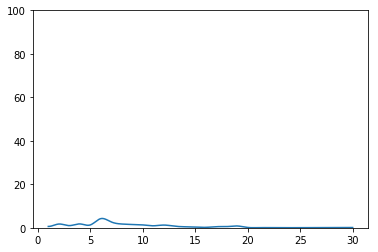

In [57]:
graph=make_interp_spline(X_plot,Y_plot)

xs=np.linspace(1,30,500)
ys=graph(xs)

plt.ylim([0, 100])
plt.plot(xs, ys)

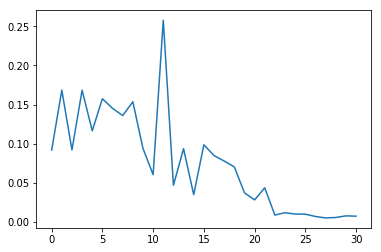

In [27]:
plt.plot(X_plot,Y_plot)

In [52]:
np.reshape([1,74,1,1,2,5,1,1,1,2,1,1,50,1,1,2,1,2,1,2,2,3300,True],(1,-1))

array([[   1,   74,    1,    1,    2,    5,    1,    1,    1,    2,    1,
           1,   50,    1,    1,    2,    1,    2,    1,    2,    2, 3300,
           1]])

In [44]:
2,63,2,1,2,5,1,1,1,1,1,2,20,4,2,2,1,2,2,2,2,1200,TRUE

array([[ 99.,  47.,   1.,   1.,   2.,   5.,   1.,   5.,   1.,   1.,   1.,
          2.,  50.,   2.,   9.,   9.,   9.,   9.,   9.,   9.,   9., 660.,
          1.]])